# Example joint fit between GBM and Swift BAT

This demonstrates 3ML's ability to to joint fit between two instruments with different likelihoods. Here, we have GBM data which obey a Poisson-Gaussian profile likelihoog (<a href=http://heasarc.gsfc.nasa.gov/docs/xanadu/xspec/manual/node293.html> PGSTAT</a> in XSPEC lingo) and Swift BAT which data which are the result of a "fit" via a coded mask and hence obey a Gaussian ( $\chi^2$ ) likelihood.

3ML automatically probes the data and selects the proper likelihood for each data set. Details for the basics of plugin setup can be found in the basic_tests example. Here we concentrate on joint fitting.

In [1]:
%matplotlib inline
%matplotlib notebook

from threeML import *
import os

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


## Plugin setup

We have data from the same time interval from Swift BAT and a GBM NAI and BGO detector. We simply read in the files and select the energy range that we want to perform the fit over.



Auto-probed noise models:
- observation: gaussian
- background: None
Range 15-150 translates to channels 3-62
Now using 60 channels out of 80



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy



<IPython.core.display.Javascript object>


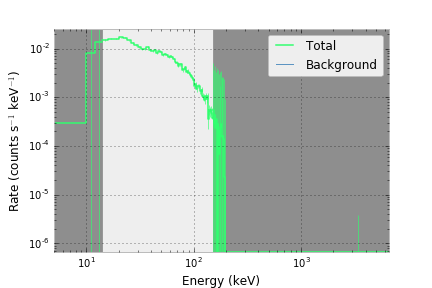

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8-900 translates to channels 2-124
Now using 123 channels out of 128



WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING UserWarning: Field 5 has a repeat count of 0 in its format code, indicating an empty field.


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING UserWarning: Could not find QUALITY in columns or header of PHA file. This is not a valid OGIP file. Assuming QUALITY =0 (good)



<IPython.core.display.Javascript object>


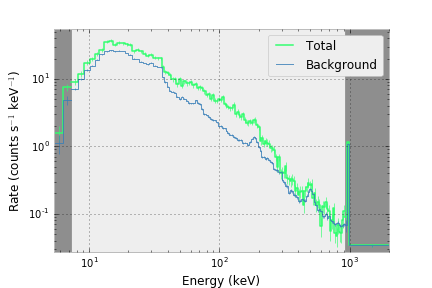

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-10000 translates to channels 1-90
Now using 90 channels out of 128



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy



<IPython.core.display.Javascript object>


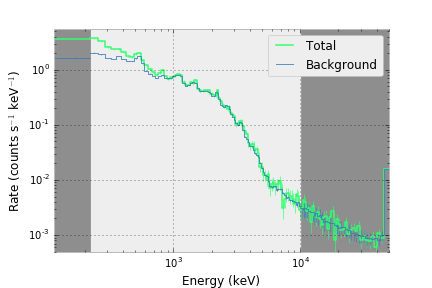

In [2]:
gbm_dir = "gbm"
bat_dir = "bat"

bat = OGIPLike('BAT',
               observation=os.path.join(bat_dir,'gbm_bat_joint_BAT.pha'),
               response=os.path.join(bat_dir,'gbm_bat_joint_BAT.rsp'))

bat.set_active_measurements('15-150')
bat.view_count_spectrum()


nai6 = OGIPLike('n6',
                os.path.join(gbm_dir,'gbm_bat_joint_NAI_06.pha'),
                os.path.join(gbm_dir,'gbm_bat_joint_NAI_06.bak'),
                os.path.join(gbm_dir,'gbm_bat_joint_NAI_06.rsp'),
                spectrum_number=1)


nai6.set_active_measurements('8-900')
nai6.view_count_spectrum()

bgo0 = OGIPLike('b0',
                os.path.join(gbm_dir,'gbm_bat_joint_BGO_00.pha'),
                os.path.join(gbm_dir,'gbm_bat_joint_BGO_00.bak'),
                os.path.join(gbm_dir,'gbm_bat_joint_BGO_00.rsp'),
                spectrum_number=1)

bgo0.set_active_measurements('250-10000')
bgo0.view_count_spectrum()

## Model setup

We setup up or spectral and likelihood model and combine the data. 3ML will automatically assign the proper likelihood to each data set.

In [3]:
band = Band()

model = Model(PointSource('joint_fit',0,0,spectral_shape=band))

data_list = DataList(bat,nai6,bgo0)


jl = JointLikelihood(model, data_list)


## Spectral fitting

Now we simply fit the data

In [4]:
_=jl.fit()

no_eac_results = jl.results

Best fit values:



,Value,Unit
joint_fit.spectrum.main.Band.K,(2.63 +/- 0.04) x 10^-2,1 / (cm2 keV s)
joint_fit.spectrum.main.Band.alpha,-1.059 +/- 0.013,
joint_fit.spectrum.main.Band.xp,(6.1 +/- 0.4) x 10^2,keV
joint_fit.spectrum.main.Band.beta,-2.42 +/- 0.19,



Correlation matrix:



1.00,0.91,-0.85,0.16
0.91,1.00,-0.72,0.10
-0.85,-0.72,1.00,-0.31
0.16,0.10,-0.31,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BAT,86.381164
b0,471.506125
n6,773.122237
total,1331.009525


It seems that the effective area between GBM and BAT do not agree! 

<IPython.core.display.Javascript object>


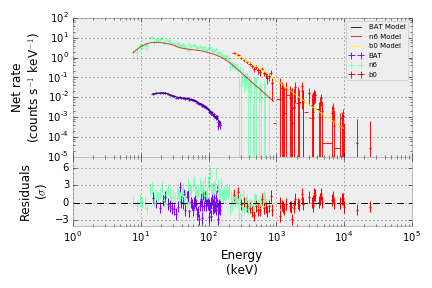

In [5]:
_=display_spectrum_model_counts(jl,step=False)

Let's add an effective area correction between the detectors to investigate the problem:

In [6]:
# turn on the effective area correction and set it's bounds

nai6.use_effective_area_correction(.2,1.8)
bgo0.use_effective_area_correction(.2,1.8)


# refit the data

_=jl.fit()

with_eac_res = jl.results


Best fit values:



,Value,Unit
joint_fit.spectrum.main.Band.K,(2.90 +/- 0.10) x 10^-2,1 / (cm2 keV s)
joint_fit.spectrum.main.Band.alpha,-1.005 +/- 0.021,
joint_fit.spectrum.main.Band.xp,(3.47 +/- 0.32) x 10^2,keV
joint_fit.spectrum.main.Band.beta,-2.42 +/- 0.20,
cons_n6,1.56 +/- 0.04,
cons_b0,1.39 +/- 0.09,



Correlation matrix:



1.00,0.96,-0.94,0.37,0.34,0.66
0.96,1.00,-0.86,0.32,0.30,0.57
-0.94,-0.86,1.00,-0.40,-0.45,-0.76
0.37,0.32,-0.40,1.00,0.05,-0.01
0.34,0.30,-0.45,0.05,1.00,0.44
0.66,0.57,-0.76,-0.01,0.44,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BAT,77.963337
b0,462.016048
n6,645.877605
total,1185.856990


Now we have a much better fit to all data sets

<IPython.core.display.Javascript object>


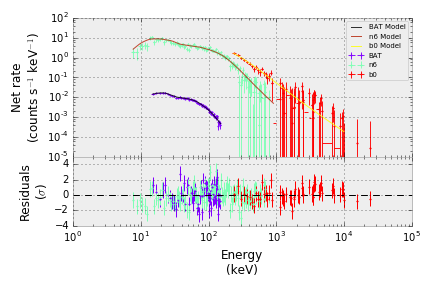

In [7]:
_=display_spectrum_model_counts(jl,step=False)

# Examining the differences

We stored the Analysis Results of each analysis. We can save them to disk, but also, we can use them to see the differences between the resulting spectral fit.

In [8]:
no_eac_results.display()

Best fit values:



,Value,Unit
joint_fit.spectrum.main.Band.K,(2.63 +/- 0.04) x 10^-2,1 / (cm2 keV s)
joint_fit.spectrum.main.Band.alpha,-1.059 +/- 0.013,
joint_fit.spectrum.main.Band.xp,(6.1 +/- 0.4) x 10^2,keV
joint_fit.spectrum.main.Band.beta,-2.42 +/- 0.19,



Correlation matrix:



1.00,0.91,-0.85,0.16
0.91,1.00,-0.72,0.10
-0.85,-0.72,1.00,-0.31
0.16,0.10,-0.31,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BAT,86.381164
b0,471.506125
n6,773.122237
total,1331.009525


In [9]:
with_eac_res.display()

Best fit values:



,Value,Unit
joint_fit.spectrum.main.Band.K,(2.90 +/- 0.10) x 10^-2,1 / (cm2 keV s)
joint_fit.spectrum.main.Band.alpha,-1.005 +/- 0.021,
joint_fit.spectrum.main.Band.xp,(3.47 +/- 0.32) x 10^2,keV
joint_fit.spectrum.main.Band.beta,-2.42 +/- 0.20,
cons_n6,1.56 +/- 0.04,
cons_b0,1.39 +/- 0.09,



Correlation matrix:



1.00,0.96,-0.94,0.37,0.34,0.66
0.96,1.00,-0.86,0.32,0.30,0.57
-0.94,-0.86,1.00,-0.40,-0.45,-0.76
0.37,0.32,-0.40,1.00,0.05,-0.01
0.34,0.30,-0.45,0.05,1.00,0.44
0.66,0.57,-0.76,-0.01,0.44,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
BAT,77.963337
b0,462.016048
n6,645.877605
total,1185.856990


Let's plot the fits in model space and see how different the resulting models are.

<IPython.core.display.Javascript object>


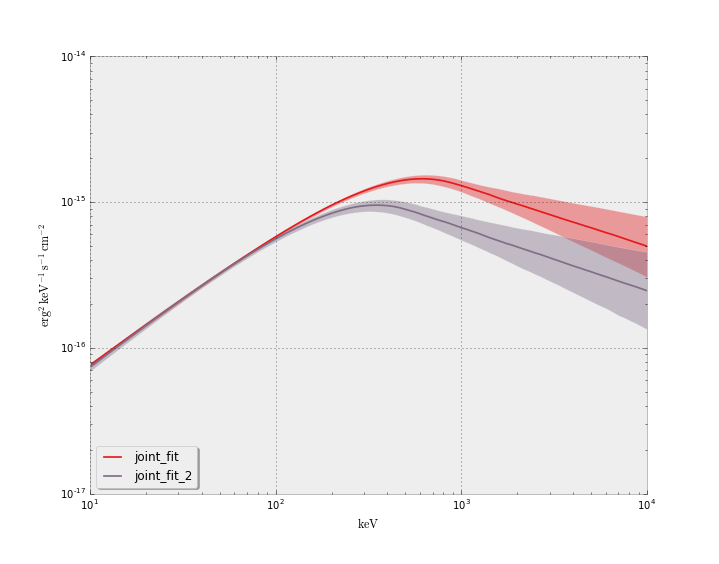

In [10]:
plot_point_source_spectra(no_eac_results,with_eac_res,flux_unit='erg2/(keV s cm2)',equal_tailed=True)